# Wetland histograms 2

**Background**

**What does this notebook do?** This notebook generates histograms of raster properties for wetland and non-wetland regions in Queensland. This is a second version of the notebook that is speedier and more clear.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

Set up the notebook and load the data.

In [6]:
import functools
from multiprocessing.pool import Pool
import multiprocessing
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import datacube.utils.geometry
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
import scipy.stats
import seaborn
from shapely.geometry import shape
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
import sklearn.metrics
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

In [7]:
dc = datacube.Datacube(app='wetland-histograms')

The wetlands shapefile contains all wetlands in QLD.

In [8]:
wetlands = gpd.read_file('/g/data/r78/ma6611/Queensland_dominant_wetland_areas_22042020.shp')

The tiles shapefile contains Claire's 25 test tiles, which Ness ran TCW/G 95 on.

In [9]:
tiles = gpd.read_file('QLDTestTiles.shp')

The wetlands are partly invalid geometry due to self-intersection, so we make a best-attempt at fixing them.

In [10]:
validity = wetlands.geometry.apply(lambda k: explain_validity(k) if k is not None else None)

In [11]:
invalid = validity != 'Valid Geometry'

In [12]:
# Fix invalid geometries.
fixed_wetlands = wetlands[invalid].geometry.buffer(0)
wetlands_original = wetlands
wetlands = wetlands.copy()
wetlands.loc[invalid, 'geometry'] = fixed_wetlands

## Sample from wetlands and non-wetlands

The tiles are way too big to fit everything in memory, but we can take an even sample of wetland and non-wetland pixels. How many wetland and non-wetland pixels do we have?

In [13]:
# Get the intersection between wetlands and tiles.
sampled_wetlands = wetlands.geometry.intersection(tiles.unary_union)

In [14]:
sampled_wetland_area = sampled_wetlands.area.sum()
sampled_wetland_area * 1e-6  # m^2 -> km^2

16097.043443814846

Compare to the area of our 25 tiles, which are each 100 km squares.

In [15]:
tiles.area.sum() * 1e-6

250000.0

How big is each pixel? If we read in (generously) 20 bands of information, each band stored as a 64-bit (= 8 bytes) float, then each pixel needs 160 bytes to store in memory. Each pixel is 625 m$^2$, so we have

In [16]:
n_wetland_pixels = sampled_wetland_area / 625
n_wetland_pixels * 160 * 1e-9

4.120843121616601

about 4 GB of memory needed to store everything. That's not too bad except that the VDI has varying amounts of memory. Let's try to keep that to 1 GB, so we sample approximately a quarter of all wetland pixels. We can sample the same amount of non-wetland pixels, so we need to sample

In [17]:
n_nonwetland_pixels = (tiles.area.sum() - sampled_wetland_area) / 625
nonwetland_sample_rate = 1 / 4 * n_wetland_pixels / n_nonwetland_pixels
nonwetland_sample_rate

0.017204831098349353

about 2% of the non-wetland pixels. We've got lots of pixels and there's no need to be precise, so we can do this with a Bernoulli random sample.

In [18]:
wetlands.WETCLASS_.unique()

array(['Lacustrine', 'Palustrine', 'Riverine'], dtype=object)

In [19]:
def get_fc(tile_index):
    fc = dc.load('fc_percentile_albers_annual', **{
        'time': '2019',
        'geopolygon': datacube.utils.geometry.Geometry(tiles.geometry[tile_index], crs='EPSG:3577'),
    })
    return fc

In [20]:
def get_tcw(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_wetness/LS_TCW_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def get_tcg(tile_label):
    tif_path_base = '/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_{}_1986_2020_summary.tif'
    tif_path = tif_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_rasterio(tif_path)
    return da

def make_wetland_mask(da):
    raster_wetland = rasterio.features.rasterize(shapes=wetlands.buffer(0),
                                                 out_shape=da.y.shape + da.x.shape,
                                                 all_touched=False,
                                                 default_value=1,
                                                 fill=0,
                                                 transform=da.geobox.transform)
    return raster_wetland.astype(bool)

def make_wetland_raster(da):
    rasters = []
    for i, wetland_class in enumerate(sorted(wetlands.WETCLASS_.unique())):
        raster_wetland = rasterio.features.rasterize(shapes=wetlands[wetlands.WETCLASS_ == wetland_class].buffer(0),
                                                     out_shape=da.y.shape + da.x.shape,
                                                     all_touched=False,
                                                     default_value=i + 1,
                                                     fill=0,
                                                     transform=da.geobox.transform)
        rasters.append(raster_wetland)
    assert (np.product(rasters, axis=0) == 0).all()
    return np.sum(rasters, axis=0)

def get_mrvbf(tile_label):
    mrvbf_path_base = mrvbf_base_path = '/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_{}.nc'
    mrvbf_path = mrvbf_path_base.format(tile_label.replace(',', '_'))
    da = xarray.open_dataset(mrvbf_path)
    return da

def get_koppen_tile(da):
    koppen = rasterio.open('/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif')  # 1km resolution
    dest = np.zeros(da.shape)
    src_transform = koppen.transform
    koppen_tile = rasterio.warp.reproject(
        koppen.read(), dest, src_crs=koppen.crs, dst_crs='EPSG:3577', src_transform=src_transform,
        dst_transform=da.transform)
    return koppen_tile[0].astype(int)

Run the following cells to generate new wetlands samples, or load an existing NetCDF file. Set `nonwetland_sample_rate` equal to `wetland_sample_rate` to disable class-balancing.

In [22]:
wetland_sample_rate = 0.1
nonwetland_sample_rate = 0.1

In [ ]:
if True:
    features = {
        'TCW': [],
        'TCG': [],
        'MrVBF': [],
        'Wetland': [],
        'x': [],
        'y': [],
        'Koppen': [],
        'PV90': [],
        'PV50': [],
        'PV10': [],
    }

    np.random.seed(1)
    for i, tile in tqdm(enumerate(tiles.itertuples()), total=len(tiles)):
        label = tile.label
        tcw = get_tcw(label)
        tcg = get_tcg(label)
        fc = get_fc(i)
        mrvbf = get_mrvbf(label).band1.isel(time=0)
        koppen = get_koppen_tile(tcw.isel(band=0))
        wet = make_wetland_raster(tcw.isel(band=0))
        mask = np.zeros(wet.shape, dtype=bool)
        mask[wet > 0] = np.random.binomial(1, 1 / 4, size=(wet > 0).sum())
        mask[wet == 0] = np.random.binomial(1, nonwetland_sample_rate, size=(wet == 0).sum())

        features['TCW'].append(tcw.values[:, mask])
        features['TCG'].append(tcg.values[:, mask])
        x, y = np.meshgrid(tcg.x, tcg.y)
        features['x'].append(x[mask])
        features['y'].append(y[mask])
        features['Wetland'].append(wet[mask])
        features['Koppen'].append(koppen[mask])
        features['MrVBF'].append(mrvbf.values[mask])

        features['PV90'].append(fc.PV_PC_90.isel(time=0).values[mask])
        features['PV50'].append(fc.PV_PC_50.isel(time=0).values[mask])
        features['PV10'].append(fc.PV_PC_10.isel(time=0).values[mask])

    features_ = {}
    for k, f in features.items():
        if len(f[0].shape) == 1:
            features_[k] = np.concatenate([a.reshape(1, -1) for a in f], axis=1)
        else:
            features_[k] = np.concatenate(f, axis=1)

    features, features_ = features_, features

    tile = []
    for i, a in enumerate(features_['x']):
        tile.extend([i] * len(a))

    df = gpd.pd.DataFrame({
        'TCW10': features['TCW'][0],
        'TCW50': features['TCW'][1],
        'TCW90': features['TCW'][2],
        'TCW95': features['TCW'][3],
        'TCG10': features['TCG'][0],
        'TCG50': features['TCG'][1],
        'TCG90': features['TCG'][2],
        'TCG95': features['TCG'][3],
        'MrVBF': features['MrVBF'][0],
        'Koppen': features['Koppen'][0],
        'Wetland': features['Wetland'][0],
        'x': features['x'][0],
        'y': features['y'][0],
        'tile': tile,
        'PV90': features['PV90'][0],
        'PV50': features['PV50'][0],
        'PV10': features['PV10'][0],
    })
    df.to_xarray().to_netcdf('wetland_data_sample_unbalanced.nc')

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


This cell loads the NetCDF back in:

In [18]:
df = xarray.open_dataset('wetland_data_sample_2.nc').to_dataframe()

We can recover an approximation of a tile by using the x and y values.

In [19]:
def spatial_plot_tile(tile, column):
    mask = df.tile == tile
    if isinstance(column, str):
        c = df[column][mask]
    else:
        c = column[mask]
    plt.scatter(df.x[mask], df.y[mask], c=c, edgecolor="None", s=2)

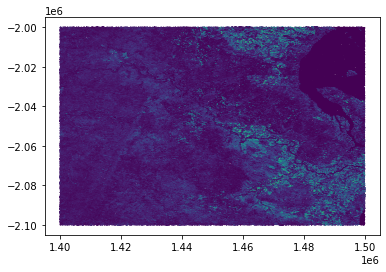

In [20]:
spatial_plot_tile(5, df.PV50 - df.PV10)

## Histograms

Let's plot density histograms for both classes.

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


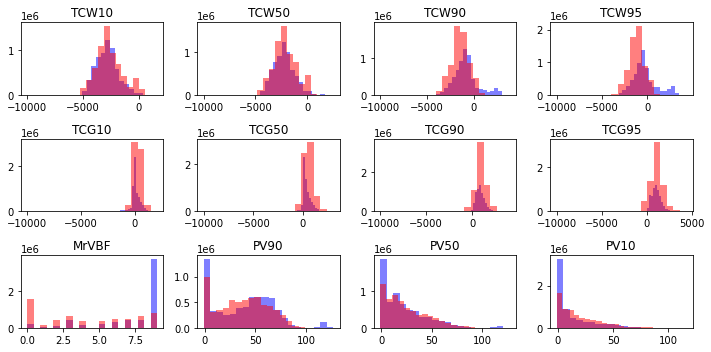

In [269]:
plt.figure(figsize=(10, 5))
for i, column in enumerate(df.columns.drop(['x', 'y', 'Wetland', 'tile', 'Koppen'])):
    plt.subplot(3, 4, i + 1)
    plt.hist(df.loc[df.Wetland > 0, column], color='blue', alpha=0.5, bins=20)
    plt.hist(df.loc[df.Wetland == 0, column], color='red', alpha=0.5, bins=20)
    plt.title(column)
plt.tight_layout()

From these histograms we can tell that there won't be a "magic bullet" where we can easily divide a feature into two to separate wetlands. Any division will need to be a function of multiple features.

We could also separate these histograms by wetland type:

In [21]:
wetland_classes = sorted(wetlands.WETCLASS_.unique())

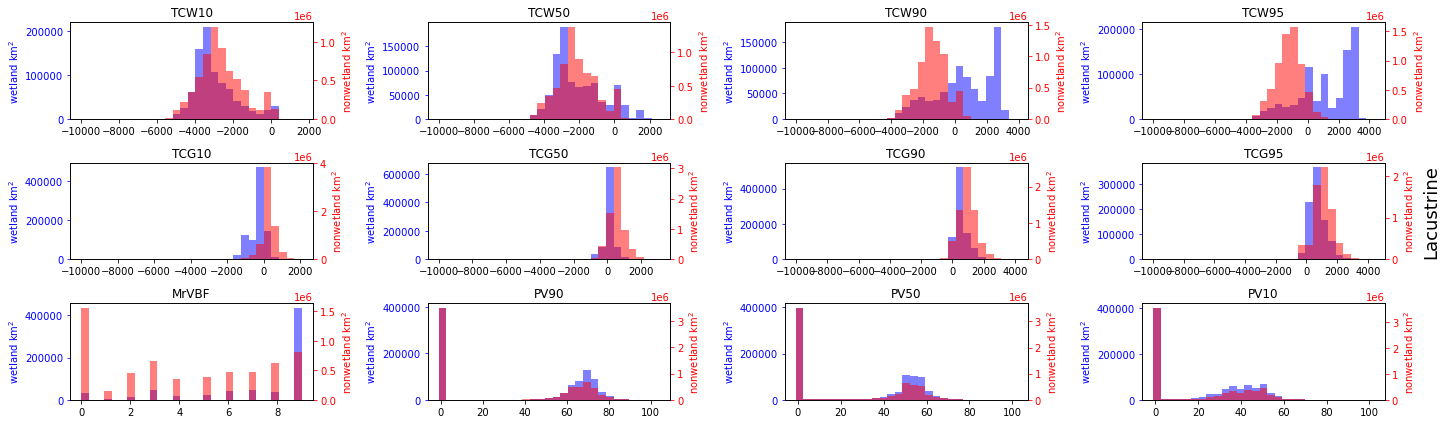

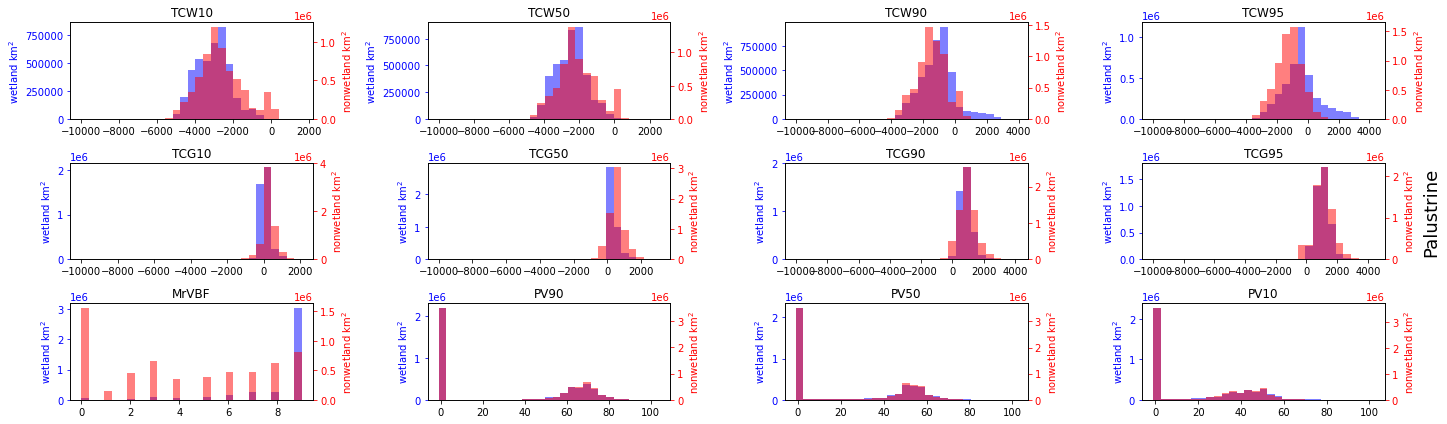

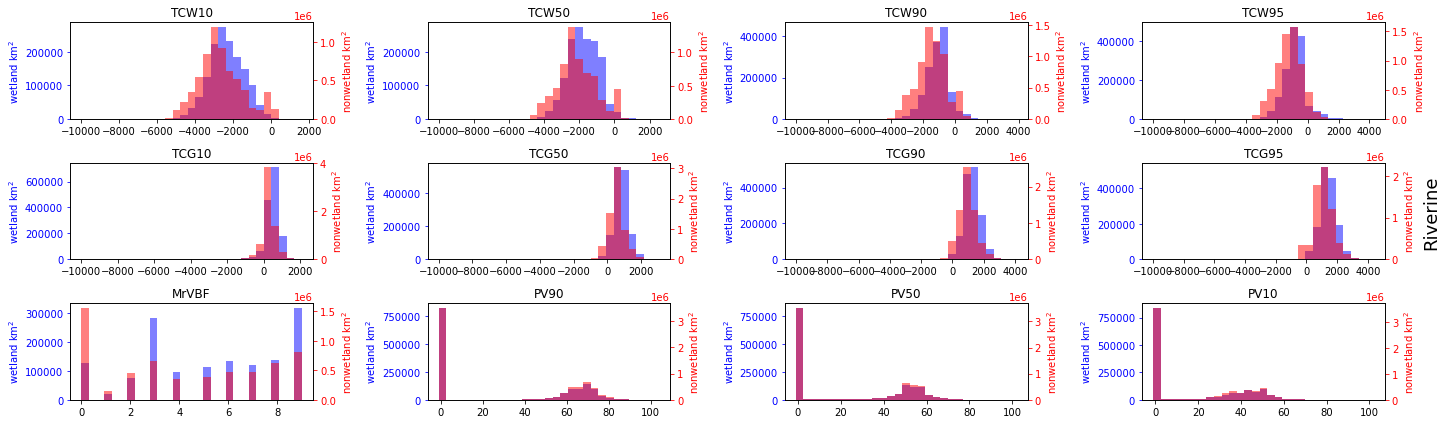

In [38]:
for wetland_class in [1, 2, 3]:
    plt.figure(figsize=(20, 6))
    for i, column in enumerate(df.columns.drop(['x', 'y', 'Wetland', 'tile', 'Koppen'])):
        ax = plt.subplot(3, 4, i + 1)
        bins = np.linspace(df[column].min(), df[column].max(), 30)
        ax.hist(df.loc[df.Wetland == wetland_class, column], color='blue', alpha=0.5, bins=bins)
        ax.set_ylabel('wetland km$^2$', fontdict={'color': 'blue'})
        ax.tick_params(axis='y', colors='blue')
        ax2 = ax.twinx()
        ax2.hist(df.loc[df.Wetland == 0, column], color='red', alpha=0.5, bins=bins)
        ax2.set_ylabel('nonwetland km$^2$', fontdict={'color': 'red'})
        ax2.tick_params(axis='y', colors='red')
        ax.set_title(column)
    plt.suptitle(wetland_classes[wetland_class - 1], rotation='vertical', x=0.99, y=0.5, fontsize=18, verticalalignment='center', horizontalalignment='left')
    plt.tight_layout()

## Finding wet things that are sometimes green

Gabrielle's threshold for wet things is TCW 95 > -600. We can apply that to find wet things:

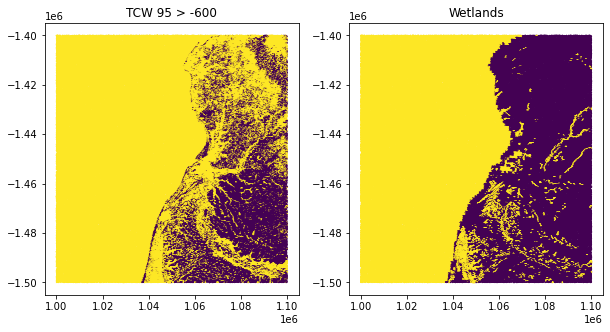

In [58]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
spatial_plot_tile(0, df.TCW95 > -600)
plt.title('TCW 95 > -600')
plt.subplot(1, 2, 2)
plt.title('Wetlands')
spatial_plot_tile(0, (df.Wetland > 0) | (df.Koppen == 0))

This clearly picks up many areas that it shouldn't (though maybe they're wet sometimes).

Let's see which features are most useful for classifying wetlands. Fit a logistic regression classifier with L1 regularisation to enforce sparsity, and look at the coefficients. We'll use the features themselves and also the difference features. We don't want to use this classifier in the end, but it might help us figure out what to look for.

In [22]:
clf_features = np.stack([
    df.TCW10,
    df.TCW50,
    df.TCW90,
    df.TCW95,
    df.TCG10,
    df.TCG50,
    df.TCG90,
    df.TCG95,
    df.PV90,
    df.PV50,
    df.PV10,
    df.MrVBF,
    df.TCW95 - df.TCW90,
    df.TCW95 - df.TCW50,
    df.TCW95 - df.TCW10,
    df.TCW90 - df.TCW50,
    df.TCW90 - df.TCW10,
    df.TCW50 - df.TCW10,
    df.TCG95 - df.TCG90,
    df.TCG95 - df.TCG50,
    df.TCG95 - df.TCG10,
    df.TCG90 - df.TCG50,
    df.TCG90 - df.TCG10,
    df.TCG50 - df.TCG10,
    df.PV90 - df.PV10,
    df.PV50 - df.PV10,
    df.PV90 - df.PV50,
]).T

In [23]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')

In [24]:
clf.fit(np.nan_to_num(clf_features[::1000]), df.Wetland[::1000] > 0)

LogisticRegression(penalty='l1', solver='liblinear')

In [25]:
predictions = clf.predict(np.nan_to_num(clf_features))

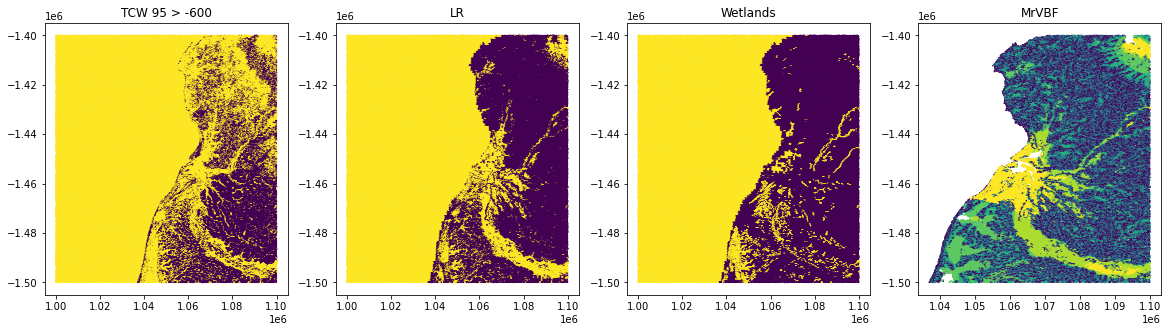

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
spatial_plot_tile(0, df.TCW95 > -600)
plt.title('TCW 95 > -600')
plt.subplot(1, 4, 2)
plt.title('LR')
spatial_plot_tile(0, predictions | (df.Koppen == 0))
plt.subplot(1, 4, 3)
plt.title('Wetlands')
spatial_plot_tile(0, (df.Wetland > 0) | (df.Koppen == 0))
plt.subplot(1, 4, 4)
plt.title('MrVBF')
spatial_plot_tile(0, df.MrVBF)

Even just visually, MrVBF is the overwhelming contribution to the logistic regression prediction. We can of course confirm this:

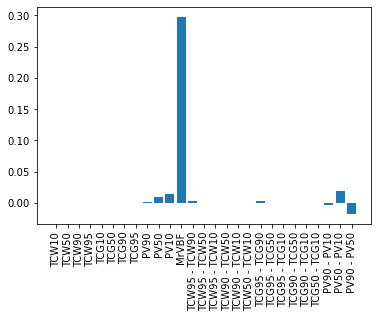

In [27]:
coefs = clf.coef_.ravel()
coef_labels = """TCW10
TCW50
TCW90
TCW95
TCG10
TCG50
TCG90
TCG95
PV90
PV50
PV10
MrVBF
TCW95 - TCW90
TCW95 - TCW50
TCW95 - TCW10
TCW90 - TCW50
TCW90 - TCW10
TCW50 - TCW10
TCG95 - TCG90
TCG95 - TCG50
TCG95 - TCG10
TCG90 - TCG50
TCG90 - TCG10
TCG50 - TCG10
PV90 - PV10
PV50 - PV10
PV90 - PV50""".split('\n')
plt.bar(range(len(coefs)), coefs)
plt.xticks(range(len(coefs)), coef_labels, rotation='vertical');

MrVBF is overwhelmingly the best predictor of wetlands. Let's fit separate logistic regression for each MrVBF zone to separate out this factor.

In [28]:
mrvbf_clfs = [sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear') for i in range(10)]

In [29]:
clf_features_nomrvbf = np.concatenate([clf_features[:, :11], clf_features[:, 12:]], axis=1)

In [30]:
for i, c in enumerate(mrvbf_clfs):
    c.fit(np.nan_to_num(clf_features_nomrvbf[df.MrVBF == i][::100]), df.Wetland[df.MrVBF == i][::100] > 0)

In [31]:
mrvbf_preds_raw = [c.predict(np.nan_to_num(clf_features_nomrvbf)) for c in mrvbf_clfs]

In [32]:
mrvbf_preds = np.zeros_like(mrvbf_preds_raw[0])
for i in range(10):
    mrvbf_preds[df.MrVBF == i] = mrvbf_preds_raw[i][df.MrVBF == i]

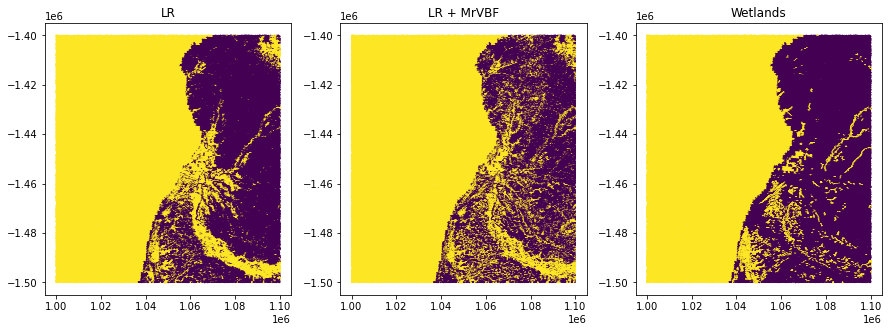

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('LR')
spatial_plot_tile(0, predictions | (df.Koppen == 0))
plt.subplot(1, 3, 2)
plt.title('LR + MrVBF')
spatial_plot_tile(0, mrvbf_preds | (df.Koppen == 0))
plt.subplot(1, 3, 3)
plt.title('Wetlands')
spatial_plot_tile(0, (df.Wetland > 0) | (df.Koppen == 0))

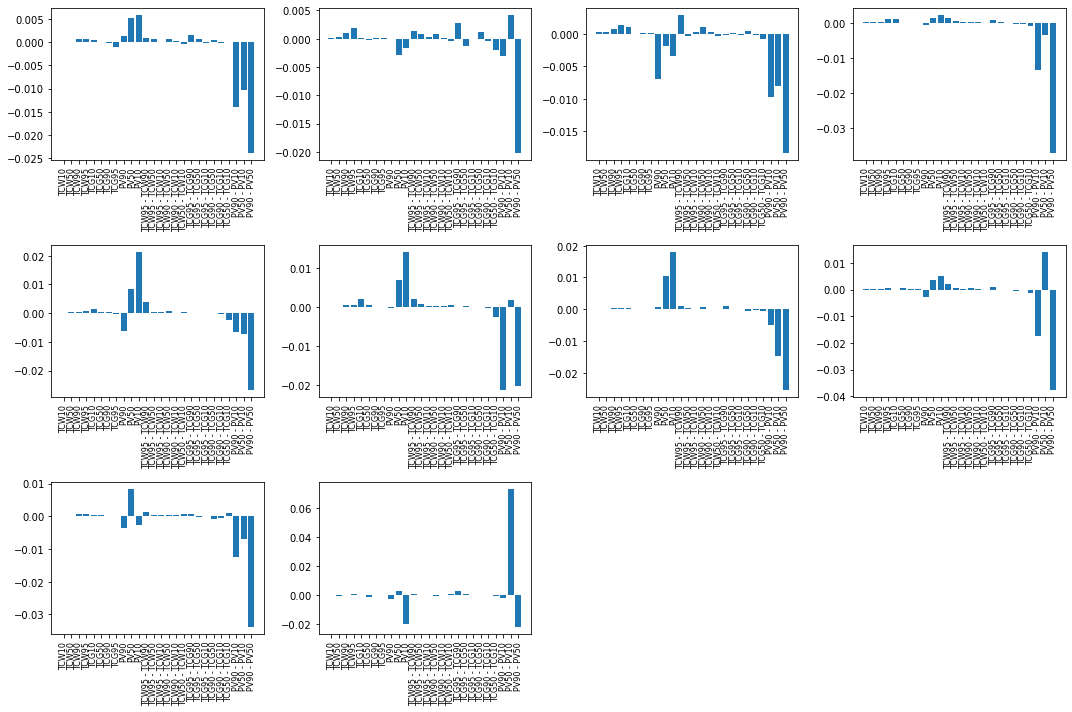

In [34]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    coefs = mrvbf_clfs[i].coef_.ravel()
    plt.bar(range(len(coefs)), coefs)
    plt.xticks(range(len(coefs)), coef_labels[:11] + coef_labels[12:], rotation='vertical', fontsize=8)
plt.tight_layout()

These plots vaguely resemble each other, so the same features should remain useful in different MrVBF areas. PV seems useful, particularly PV 10; TCW 95 seems useful, TCG 95 - TCG 90 seems useful, and PV 50 - PV 10 seems useful too.

MrVBF already seems to have a lot of wetland information in it. Let's look at MrVBF vs TCW 95.

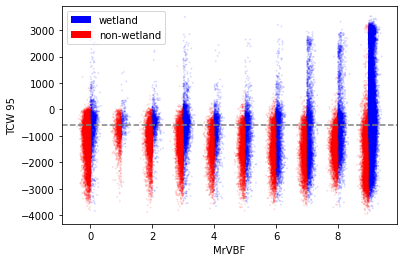

In [35]:
df_ = df[::100]
offset = np.where(df_.Wetland > 0, 1, -1) * np.abs(np.random.normal(scale=0.1, size=len(df_)))
plt.scatter(df_.MrVBF + offset, df_.TCW95, c=df_.Wetland > 0, cmap='bwr_r', s=1, alpha=0.1)
plt.xlabel('MrVBF')
plt.ylabel('TCW 95')
blue = matplotlib.patches.Patch(facecolor='blue')
red = matplotlib.patches.Patch(facecolor='red')
plt.axhline(-600, color='grey', linestyle='--')
plt.legend([blue, red], ['wetland', 'non-wetland'], loc='upper left')

And again against TCG 50:

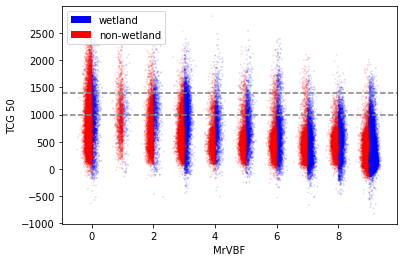

In [38]:
df_ = df[::100]
offset = np.where(df_.Wetland > 0, 1, -1) * np.abs(np.random.normal(scale=0.1, size=len(df_)))
plt.scatter(df_.MrVBF + offset, df_.TCG50, c=df_.Wetland > 0, cmap='bwr_r', s=1, alpha=0.1)
plt.xlabel('MrVBF')
plt.ylabel('TCG 50')
blue = matplotlib.patches.Patch(facecolor='blue')
red = matplotlib.patches.Patch(facecolor='red')
plt.axhline(1000, color='grey', linestyle='--')
plt.axhline(1400, color='grey', linestyle='--')
plt.legend([blue, red], ['wetland', 'non-wetland'], loc='upper left')

And against PV variation:

In [43]:
wetland_classes

['Lacustrine', 'Palustrine', 'Riverine']

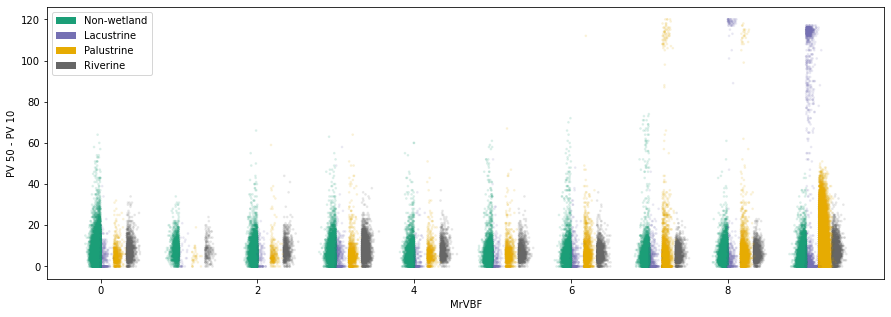

In [74]:
df_ = df[::100]
plt.figure(figsize=(15, 5))
offset = np.where(df_.Wetland > 0, 1, -1) * np.abs(np.random.normal(scale=0.05, size=len(df_))) + np.where(df_.Wetland, df_.Wetland - 1, 0) / 6
cmap = matplotlib.cm.Dark2
plt.scatter(df_.MrVBF + offset, df_.PV50 - df_.PV10, c=df_.Wetland, cmap=cmap, s=3, alpha=0.1)
plt.xlabel('MrVBF')
plt.ylabel('PV 50 - PV 10')
patches = [matplotlib.patches.Patch(facecolor=cmap(i / 3)) for i in range(4)]
plt.legend(patches, ['Non-wetland'] + wetland_classes, loc='upper left')

Let's see how Gabrielle's greenness mask affects this split.

In [84]:
def make_gabrielle_mask():
    low = df.MrVBF >= 3
    # Apply wetness threshold
    wet = df.TCW95 > -600
    # Apply greenness threshold - binary
    green_high = df.TCG50 > 1000
    green_low = df.TCG50 > 1400
    # Mask greenness by mrvbf - binary + nan
    green_high_mrvbf = green_high.where(~low)
    green_low_mrvbf = green_low.where(low)
    # Combine into one greenness mask
    green_combo = np.nansum(np.dstack((green_high_mrvbf, green_low_mrvbf)), 2).astype(bool)
    return ~green_combo[0]
gabrielle_mask = make_gabrielle_mask()

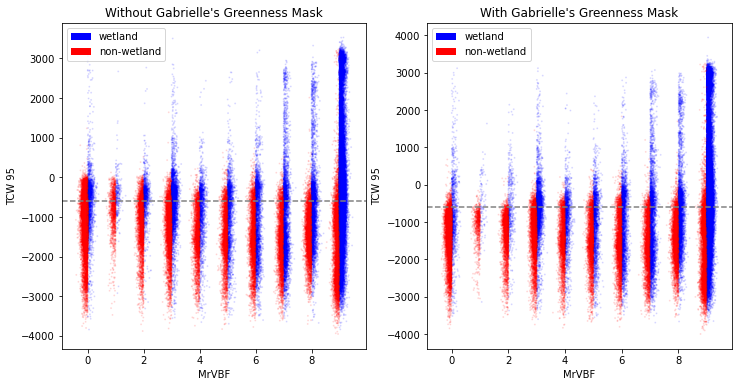

In [331]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
df_ = df[gabrielle_mask][::100]
plt.title('With Gabrielle\'s Greenness Mask')
offset = np.where(df_.Wetland > 0, 1, -1) * np.abs(np.random.normal(scale=0.1, size=len(df_)))
plt.scatter(df_.MrVBF + offset, df_.TCW95, c=df_.Wetland > 0, cmap='bwr_r', s=1, alpha=0.1)
plt.xlabel('MrVBF')
plt.ylabel('TCW 95')
blue = matplotlib.patches.Patch(facecolor='blue')
red = matplotlib.patches.Patch(facecolor='red')
plt.axhline(-600, color='grey', linestyle='--')
plt.legend([blue, red], ['wetland', 'non-wetland'], loc='upper left')
plt.subplot(1, 2, 1)
plt.title('Without Gabrielle\'s Greenness Mask')
df_ = df[::100]
offset = np.where(df_.Wetland > 0, 1, -1) * np.abs(np.random.normal(scale=0.1, size=len(df_)))
plt.scatter(df_.MrVBF + offset, df_.TCW95, c=df_.Wetland > 0, cmap='bwr_r', s=1, alpha=0.1)
plt.xlabel('MrVBF')
plt.ylabel('TCW 95')
blue = matplotlib.patches.Patch(facecolor='blue')
red = matplotlib.patches.Patch(facecolor='red')
plt.axhline(-600, color='grey', linestyle='--')
plt.legend([blue, red], ['wetland', 'non-wetland'], loc='upper left')

It might also be useful to check the confusion matrices for both of these. Let's start with just a full confusion matrix:

In [195]:
# Swiped from sklearn: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalise=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting `normalise=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix, without normalisation')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.02f}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalised confusion matrix
[[0.7790796  0.2209204 ]
 [0.44585731 0.55414269]]
Normalised confusion matrix
[[0.86123742 0.13876258]
 [0.48500283 0.51499717]]


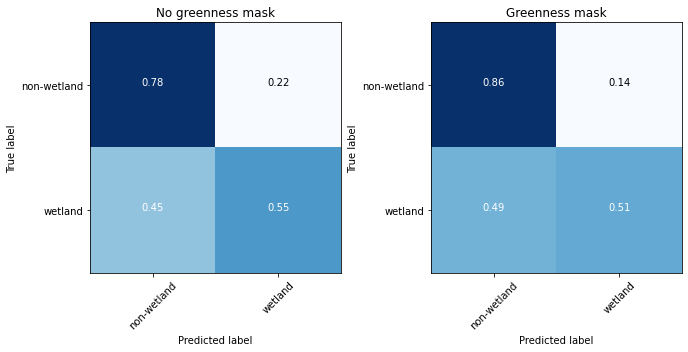

In [196]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(df.Wetland > 0, df.TCW95 > -600), ['non-wetland', 'wetland'], normalise=True, title='No greenness mask')
plt.subplot(1, 2, 2)
plot_confusion_matrix(sklearn.metrics.confusion_matrix(df.Wetland > 0, (df.TCW95 > -600) & gabrielle_mask), ['non-wetland', 'wetland'], normalise=True, title='Greenness mask')

This is a great way to split out wetlands, but we also need something to distil the confusion at high values of MrVBF. But let's drill down even further. What are we actually confusing here?

In [41]:
koppen_zones = sorted(set(df.Koppen.unique()) - {7, 15})  # Not enough samples of 7 and 9
len(koppen_zones)

8

In [346]:
koppen_titles = ['Ocean', 'Af', 'Am', 'Aw', 'BWh', 'BWk', 'BSh', 'BSk', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb', 'Cwc',
                 'Cfa', 'Cfb', 'Cfc', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd', 'Dfa',
                 'Dfb', 'Dfc', 'Dfd', 'ET', 'EF']

In [43]:
# https://gka.github.io/palettes/#/4|d|e6037c,a82cd0,a7a88b|000000,17439b,4176ff|1|1
cm = matplotlib.colors.ListedColormap(["#e6037c", "#b27ea499", "#233a7f99", "#4176ff99"])
names = ["Non-wetland"] + wetland_classes
patches = []

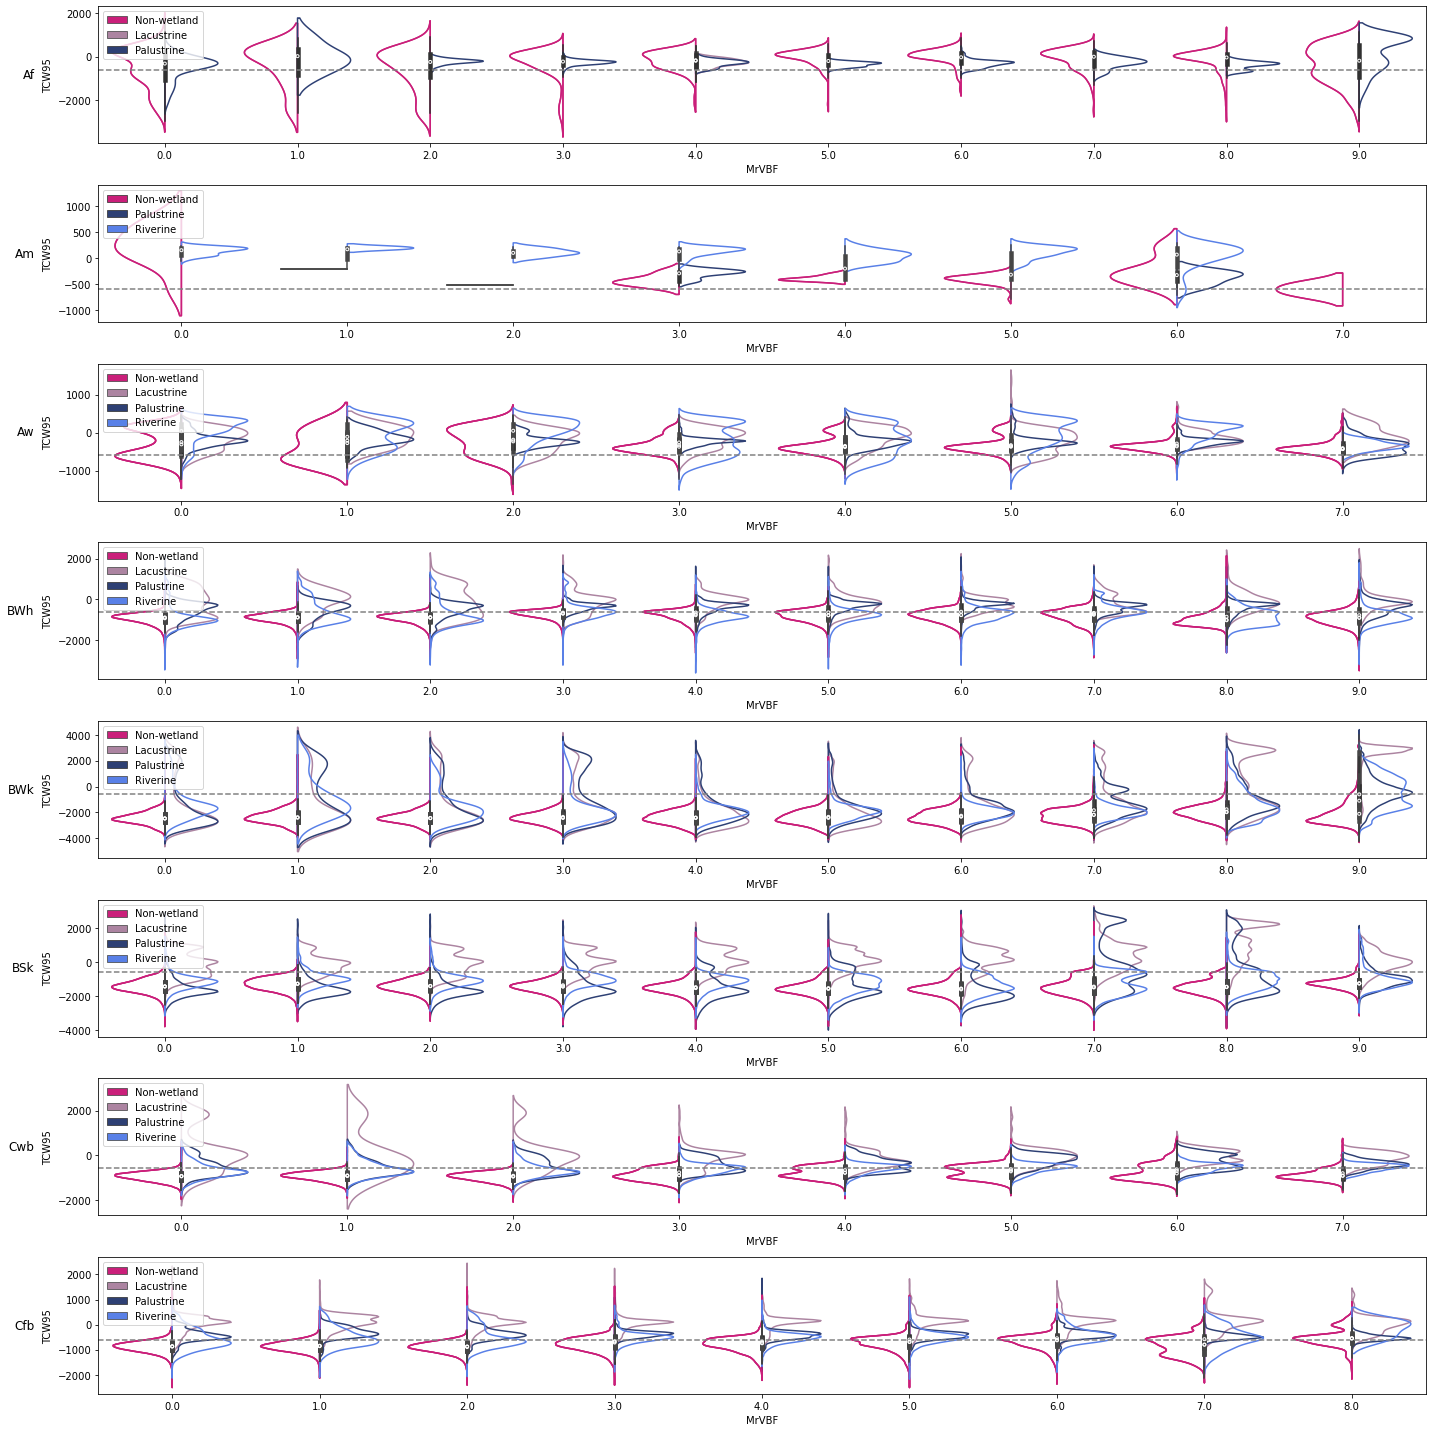

In [350]:
%matplotlib inline
plt.figure(figsize=(20, 20))
nrows = 8
for koppen_zone_i in range(nrows):
    ax = plt.subplot(nrows, 1, koppen_zone_i + 1)

    df_ = df[(df.Koppen == koppen_zones[koppen_zone_i]) & gabrielle_mask]

    # Split violin plot of wetlands vs non-wetlands in this koppen zone.
    for wetland_class_i in range(1, 4):
        df__ = df_[df_.Wetland.isin({wetland_class_i, 0})]
        if len(df__.Wetland.unique()) == 2:
            hue = np.where(df__.Wetland == 0, "Non-wetland", names[wetland_class_i])
            vp = seaborn.violinplot(
                x=df__.MrVBF,
                y=df__.TCW95,
                hue=hue,
                split=True,
                ax=ax,
                hue_order=["Non-wetland", names[wetland_class_i]],
                palette=dict(zip(names, cm.colors)),
                legend=False,
                scale='width',
                # alpha=0.333,  # Seaborn doesn't support this
            )
    for c in ax.collections:
        c.set_alpha(1)
        c.set_edgecolor(c.get_facecolor())
        c.set_facecolor('None')

    # Drop repeated non-wetland labels. This comes from tricking seaborn into making split plots with multiple right halves...
    handles, labels = ax.get_legend_handles_labels()
    handles_ = []
    labels_ = []
    for i in range(len(handles)):
        if i == 0 or i % 2:
            handles_.append(handles[i])
            labels_.append(labels[i])
    ax.legend(handles=handles_,
              labels=labels_, loc='upper left')

    ax.annotate(
        koppen_titles[koppen_zones[koppen_zone_i]],
        xy=(0, 0.5),
        xytext=(-ax.yaxis.labelpad - 5, 0),
        xycoords=ax.yaxis.label,
        textcoords="offset points",
        size="large",
        ha="right",
        va="center",
    )
    plt.axhline(-600, color="grey", linestyle="--")

    plt.tight_layout()

Let's look at PV variation vs TCW 95. First, we'll ignore MrVBF.

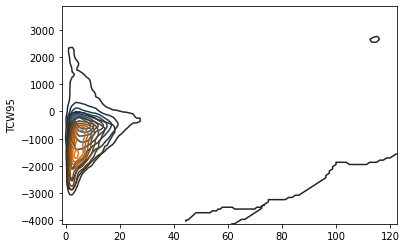

In [75]:
df_ = df[(df.Wetland > 0) & ((df.PV50 - df.PV10) > 0)][::100]
seaborn.kdeplot(df_.PV50 - df_.PV10, df_.TCW95)
df_ = df[(df.Wetland == 0) & ((df.PV50 - df.PV10) > 0)][::100]
seaborn.kdeplot(df_.PV50 - df_.PV10, df_.TCW95)

Do we have a hope of distinguishing wetlands from non-wetlands? To find out, let's use a nearest-neighbour classifier in the feature space to colour the spatial images.

In [76]:
import sklearn.neighbors

In [159]:
clf_features = np.stack([
    df.TCW95,
    df.TCG50,
    df.PV90,
    df.PV10,
    df.MrVBF,
    df.Koppen,
    df.TCW95 - df.TCW90,
    df.TCG95 - df.TCG90,
    df.TCG50 - df.TCG10,
    df.PV50 - df.PV10,
]).T

In [160]:
clf_features_scaled = clf_features - clf_features.mean(axis=0)
clf_mean = clf_features.mean(axis=0)
clf_std = clf_features_scaled.std(axis=0)
clf_features_scaled /= clf_features_scaled.std(axis=0)

In [79]:
knc = sklearn.neighbors.KNeighborsClassifier(n_jobs=4, n_neighbors=20)

In [198]:
mask = df.tile != 5  # 5 will be our test tile because Gabrielle says it has tricky forests.
knc.fit(np.nan_to_num(clf_features_scaled[mask][::100]), df.Wetland[mask][::100] > 0)

KNeighborsClassifier(n_jobs=4, n_neighbors=20)

In [199]:
knc_predictions = knc.predict(np.nan_to_num(clf_features_scaled[df.tile == 5]))

KeyboardInterrupt: 

In [82]:
prediction_values = np.zeros(len(df), dtype=bool)
prediction_values[df.tile == 5] = knc_predictions

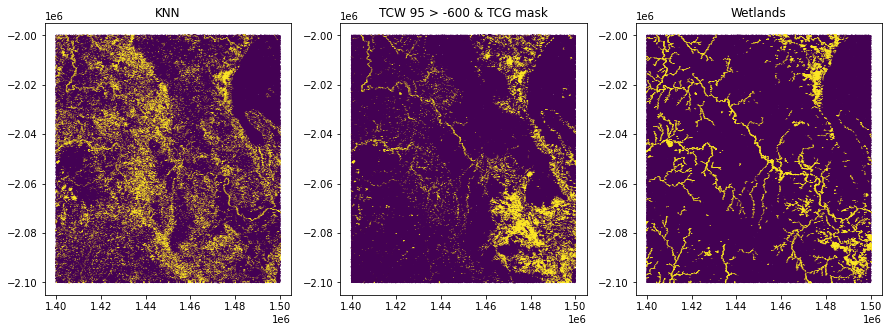

In [85]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('KNN')
spatial_plot_tile(5, prediction_values)
plt.subplot(1, 3, 2)
plt.title('TCW 95 > -600 & TCG mask')
spatial_plot_tile(5, ((df.TCW95 > -600) & gabrielle_mask) & (df.Koppen != 0))
plt.subplot(1, 3, 3)
plt.title('Wetlands')
spatial_plot_tile(5, df.Wetland > 0)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


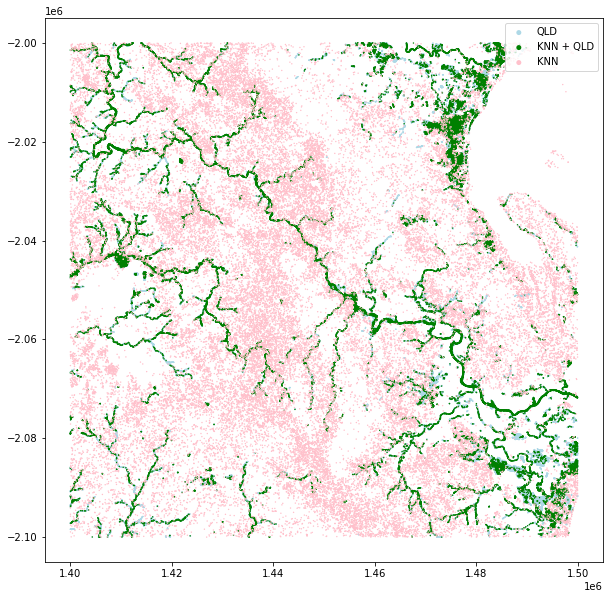

In [86]:
plt.figure(figsize=(10, 10))
tile = 5
mask = (df.tile == tile) & ~prediction_values.astype(bool) & (df.Wetland > 0)
plt.scatter(df.x[mask], df.y[mask], c='lightblue', edgecolor="None", s=2, label='QLD')
mask = (df.tile == tile) & prediction_values & (df.Wetland > 0)
plt.scatter(df.x[mask], df.y[mask], c='green', edgecolor="None", s=2, label='KNN + QLD')
mask = (df.tile == tile) & prediction_values & (df.Wetland == 0)
plt.scatter(df.x[mask], df.y[mask], c='pink', edgecolor="None", s=2, label='KNN')
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_sizes([25])

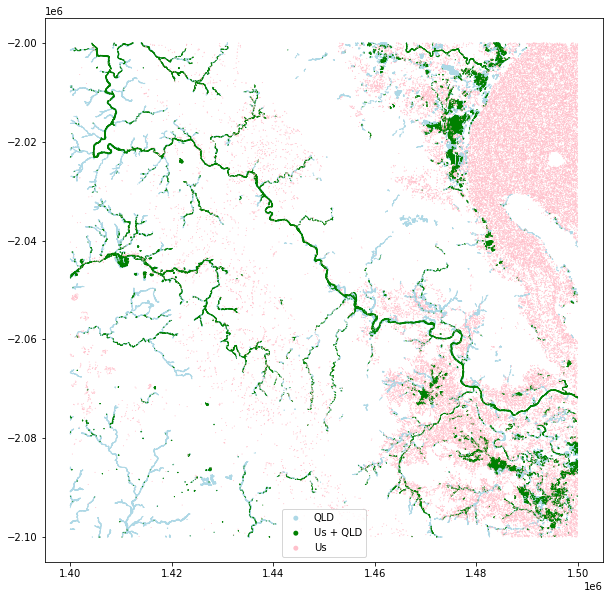

In [220]:
plt.figure(figsize=(10, 10))
tile = 5
gabrielle_prediction = (df.TCW95 > -600) & gabrielle_mask
mask = (df.tile == tile) & ~gabrielle_prediction & (df.Wetland > 0)
plt.scatter(df.x[mask], df.y[mask], c='lightblue', edgecolor="None", s=1, label='QLD')
mask = (df.tile == tile) & gabrielle_prediction & (df.Wetland > 0)
plt.scatter(df.x[mask], df.y[mask], c='green', edgecolor="None", s=1, label='Us + QLD')
mask = (df.tile == tile) & gabrielle_prediction & (df.Wetland == 0)
plt.scatter(df.x[mask], df.y[mask], c='pink', edgecolor="None", s=1, label='Us')
legend = plt.legend()
for handle in legend.legendHandles:
    handle.set_sizes([25])

In [103]:
sat_image = dc.load('ls8_nbart_geomedian_annual', **{
        'time': '2019',
        'geopolygon': datacube.utils.geometry.Geometry(tiles.geometry[5], crs='EPSG:3577'),
    })

It would be really useful to home in on this tiny section with full resolution.

In [87]:
def get_tcw_bounds(tile_label, xlim, ylim):
    da = get_tcw(tile_label)
    return da.sel(x=slice(*xlim), y=slice(*ylim))

def get_tcg_bounds(tile_label, xlim, ylim):
    da = get_tcg(tile_label)
    return da.sel(x=slice(*xlim), y=slice(*ylim))

def make_wetland_raster_bounds(da, xlim, ylim):
    raster = make_wetland_raster(da)
    raster_da = xarray.DataArray(raster, da.coords)
    return raster_da.sel(x=slice(*xlim), y=slice(*ylim))

def get_mrvbf_bounds(tile_label, xlim, ylim):
    da = get_mrvbf(tile_label)
    return da.sel(x=slice(*xlim), y=slice(*ylim))

def get_koppen_tile_bounds(da, xlim, ylim):
    koppen_da = xarray.DataArray(get_koppen_tile(da), coords=da.coords)
    return koppen_da.sel(x=slice(*xlim), y=slice(*ylim))

In [88]:
def get_fc_bounds(tile_index, xlim, ylim):
    da = get_fc(tile_index)
    return da.sel(x=slice(*xlim), y=slice(*ylim))

In [112]:
xlim = (1.46e6, 1.48e6)
ylim = (-2.02e6, -2.00e6)

In [113]:
tcw_ = get_tcw_bounds(tiles.label[5], xlim, ylim[::-1])
tcg_ = get_tcg_bounds(tiles.label[5], xlim, ylim[::-1])
vbf_ = get_mrvbf_bounds(tiles.label[5], xlim, ylim[::-1])

In [114]:
kop_ = get_koppen_tile_bounds(tcw_.isel(band=0), xlim, ylim[::-1])

In [115]:
wet_ = make_wetland_raster_bounds(tcw_.isel(band=0), xlim, ylim[::-1])

In [116]:
fc_ = get_fc_bounds(5, xlim, ylim[::-1])

In [117]:
def make_gabrielle_mask_tiny():
    low = vbf_.band1.isel(time=0) >= 3
    # Apply wetness threshold
    wet = tcw_.isel(band=3) > -600
    # Apply greenness threshold - binary
    green_high = tcg_.isel(band=1) > 1000
    green_low = tcg_.isel(band=1) > 1400
    # Mask greenness by mrvbf - binary + nan
    green_high_mrvbf = green_high.where(~low)
    green_low_mrvbf = green_low.where(low)
    # Combine into one greenness mask
    green_combo = np.nansum(np.dstack((green_high_mrvbf, green_low_mrvbf)), 2).astype(bool)
    return ~green_combo

In [161]:
tiny_features = np.stack([
    tcw_.isel(band=3).values,  # df.TCW95,
    tcg_.isel(band=1).values,  # df.TCG50,
    fc_.PV_PC_90.isel(time=0).values,  # df.PV90,
    fc_.PV_PC_10.isel(time=0).values,  # df.PV10,
    vbf_.band1.isel(time=0).values,  # df.MrVBF,
    kop_.values,
    (tcw_.isel(band=3) - tcw_.isel(band=2)).values,  # df.TCW95 - df.TCW90,
    (tcg_.isel(band=3) - tcg_.isel(band=2)).values,  # df.TCG95 - df.TCG90,
    (tcg_.isel(band=1) - tcg_.isel(band=0)).values,  # df.TCG50 - df.TCG10,
    (fc_.PV_PC_50.isel(time=0) - fc_.PV_PC_10.isel(time=0)).values,  # df.PV50 - df.PV10,
]).T

In [163]:
tiny_features = tiny_features - clf_mean
tiny_features /= clf_std

In [120]:
prd_ = knc.predict(np.nan_to_num(tiny_features.reshape((-1, tiny_features.shape[-1]))))

In [121]:
prd_ = prd_.reshape(tiny_features.shape[:-1])

In [122]:
gabrielle_mask_ = make_gabrielle_mask_tiny()

(1460000.0, 1480000.0)

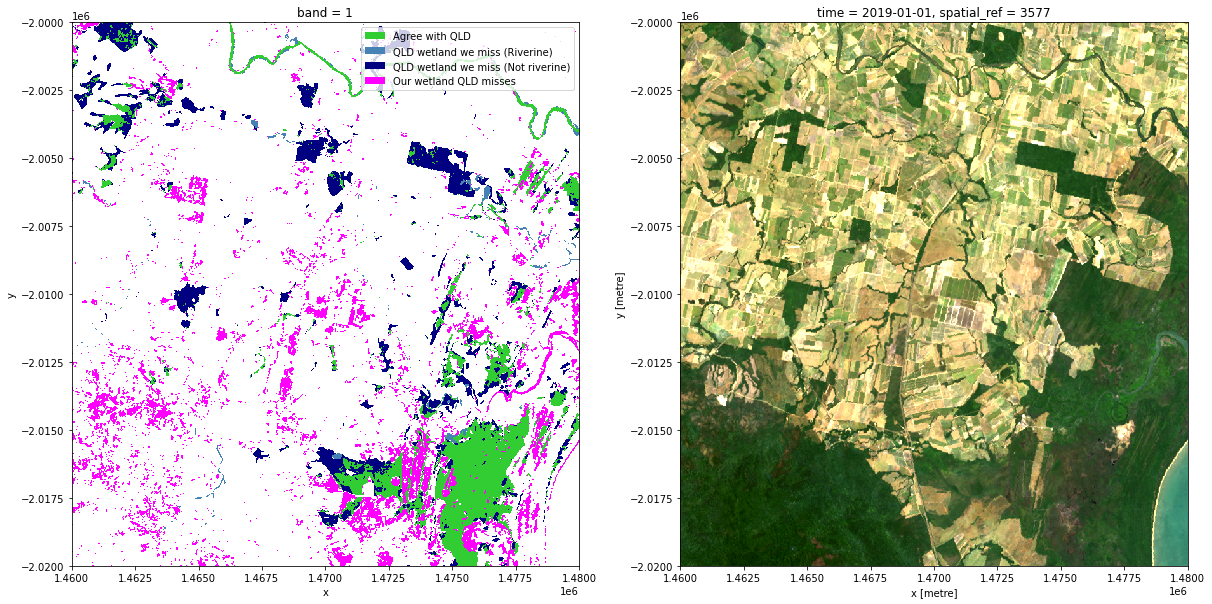

In [123]:
plt.figure(figsize=(20, 10))
tile = 5
s = 2
plt.subplot(1, 2, 1)
plt.title('KNN')
masks = {'Agree with QLD': prd_.T & (wet_ > 0),
         'QLD wetland we miss (Riverine)': ~prd_.T & (wet_ == 3),
         'QLD wetland we miss (Not riverine)': ~prd_.T & (wet_ != 3) & (wet_ > 0),
         'Our wetland QLD misses': prd_.T & (wet_ == 0)}
colours = {'Agree with QLD': 'limegreen',
         'QLD wetland we miss (Riverine)': 'steelblue',
         'QLD wetland we miss (Not riverine)': 'navy',
         'Our wetland QLD misses': 'magenta'}

labels, handles = zip(*colours.items())
handles = [matplotlib.patches.Patch(facecolor=c) for c in handles]
for label, mask in masks.items():
    mask.plot.imshow(cmap=matplotlib.colors.ListedColormap(['#00000000', colours[label]]), add_colorbar=False, interpolation='gaussian')
plt.legend(handles, labels)

ax = plt.subplot(1, 2, 2)
rgb(sat_image.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
plt.ylim(ylim)
plt.xlim(xlim)

(1460000.0, 1480000.0)

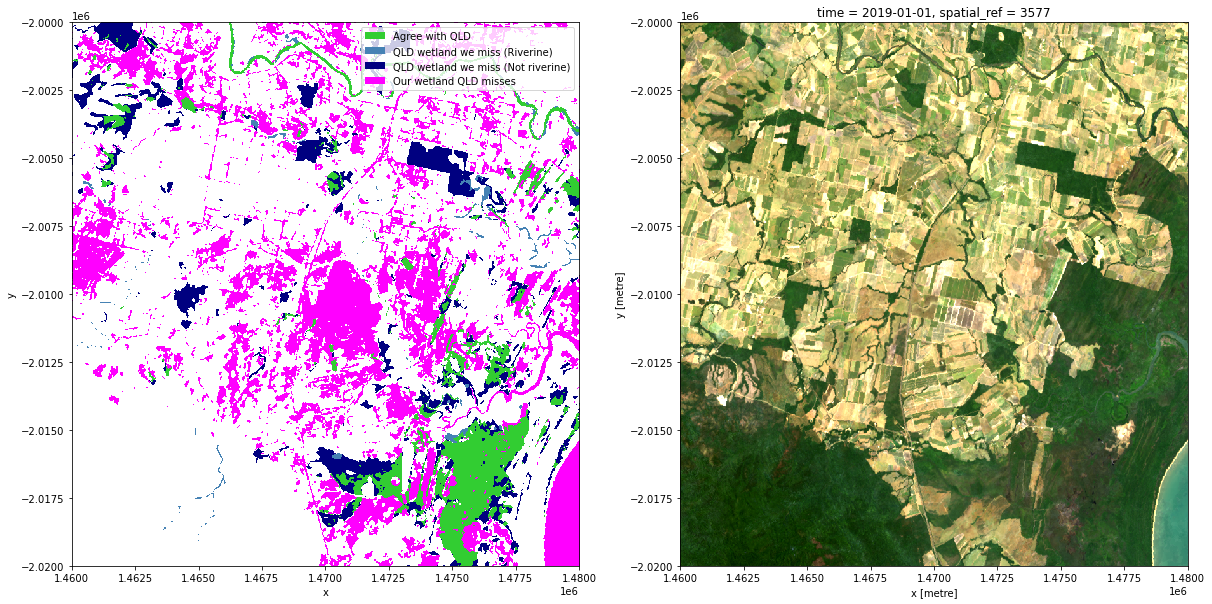

In [191]:
plt.figure(figsize=(20, 10))
tile = 5
s = 2
plt.subplot(1, 2, 1)
gabrielle_prediction = ((tcw_.isel(band=3) > -600) & gabrielle_mask_)

masks = {'Agree with QLD': gabrielle_prediction & (wet_ > 0),
         'QLD wetland we miss (Riverine)': ~gabrielle_prediction & (wet_ == 3),
         'QLD wetland we miss (Not riverine)': ~gabrielle_prediction & (wet_ != 3) & (wet_ > 0),
         'Our wetland QLD misses': gabrielle_prediction & (wet_ == 0)}
colours = {'Agree with QLD': 'limegreen',
         'QLD wetland we miss (Riverine)': 'steelblue',
         'QLD wetland we miss (Not riverine)': 'navy',
         'Our wetland QLD misses': 'magenta'}

labels, handles = zip(*colours.items())
handles = [matplotlib.patches.Patch(facecolor=c) for c in handles]
for label, mask in masks.items():
    mask.plot.imshow(cmap=matplotlib.colors.ListedColormap(['#00000000', colours[label]]), add_colorbar=False, interpolation='gaussian')
plt.legend(handles, labels)

ax = plt.subplot(1, 2, 2)
rgb(sat_image.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
plt.ylim(ylim)
plt.xlim(xlim)

In [350]:
import sklearn.tree
clf2 = sklearn.ensemble.RandomForestClassifier()

In [351]:
mask = df.tile != 5
clf2.fit(np.nan_to_num(clf_features_scaled[mask][::100]), df.Wetland[mask][::100] > 0)

RandomForestClassifier()

In [352]:
prd_2 = clf2.predict(np.nan_to_num(tiny_features.reshape((-1, tiny_features.shape[-1])))).reshape(tiny_features.shape[:-1])

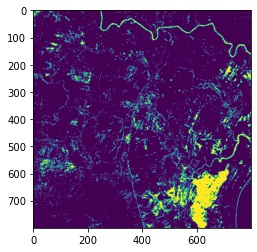

In [353]:
plt.imshow(prd_2.T)

In [354]:
feat_ = np.nan_to_num(tiny_features.reshape((-1, tiny_features.shape[-1])))
feat_.shape

(640000, 10)

In [355]:
knc.score(feat_, wet_.values.ravel() > 0)

KeyboardInterrupt: 

In [ ]:
sklearn.metrics.accuracy_score(gabrielle_prediction.values.ravel(), wet_.values.ravel() > 0)

(1460000.0, 1480000.0)

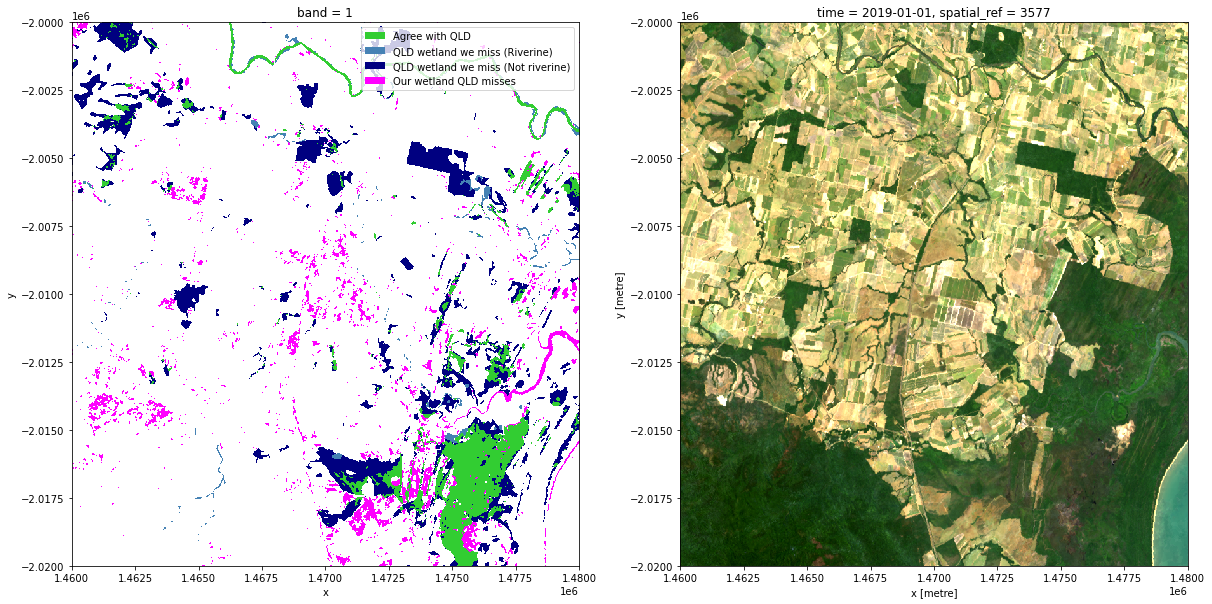

In [356]:
plt.figure(figsize=(20, 10))
tile = 5
s = 2
plt.subplot(1, 2, 1)
plt.title('CLF2')
masks = {'Agree with QLD': prd_2.T & (wet_ > 0),
         'QLD wetland we miss (Riverine)': ~prd_2.T & (wet_ == 3),
         'QLD wetland we miss (Not riverine)': ~prd_2.T & (wet_ != 3) & (wet_ > 0),
         'Our wetland QLD misses': prd_2.T & (wet_ == 0)}
colours = {'Agree with QLD': 'limegreen',
         'QLD wetland we miss (Riverine)': 'steelblue',
         'QLD wetland we miss (Not riverine)': 'navy',
         'Our wetland QLD misses': 'magenta'}

labels, handles = zip(*colours.items())
handles = [matplotlib.patches.Patch(facecolor=c) for c in handles]
for label, mask in masks.items():
    mask.plot.imshow(cmap=matplotlib.colors.ListedColormap(['#00000000', colours[label]]), add_colorbar=False, interpolation='gaussian')
plt.legend(handles, labels)

ax = plt.subplot(1, 2, 2)
rgb(sat_image.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
plt.ylim(ylim)
plt.xlim(xlim)

In [172]:
clf2.score(tiny_features)

array([0.22114932, 0.14117445, 0.06368672, 0.0754088 , 0.        ,
       0.13795211, 0.13210847, 0.09428685, 0.09179806, 0.04243521])

(1460000.0, 1480000.0)

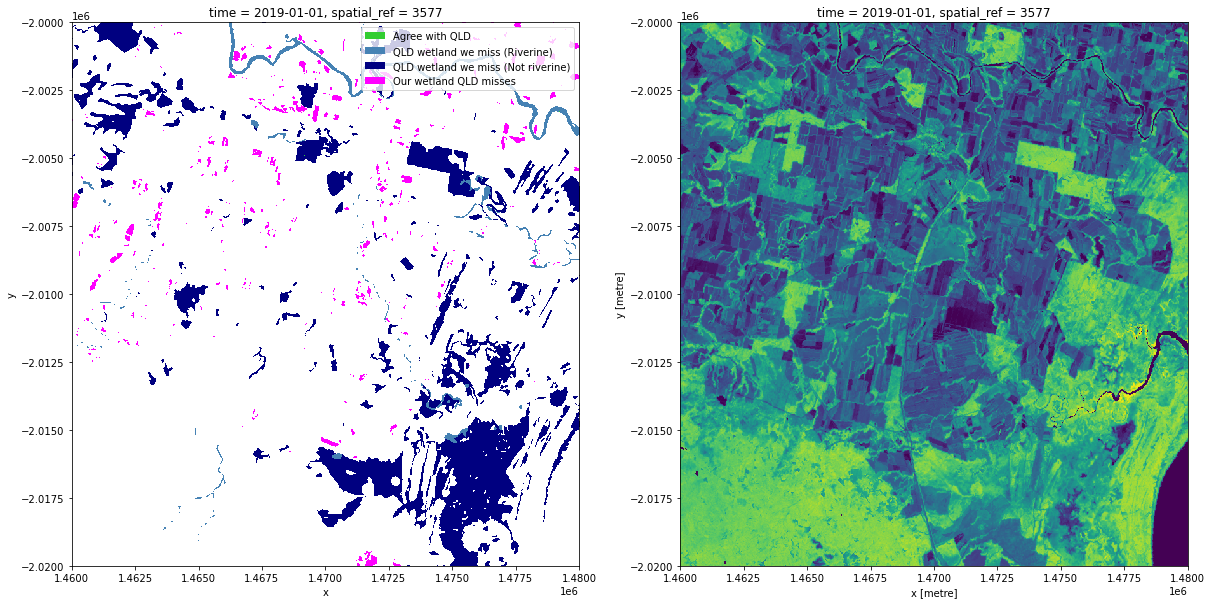

In [142]:
plt.figure(figsize=(20, 10))
tile = 5
s = 2
plt.subplot(1, 2, 1)
gabrielle_prediction = ((tcw_.isel(band=3) > -600) & (fc_.PV_PC_50.isel(time=0) - fc_.PV_PC_10.isel(time=0) > 50))

masks = {'Agree with QLD': gabrielle_prediction & (wet_ > 0),
         'QLD wetland we miss (Riverine)': ~gabrielle_prediction & (wet_ == 3),
         'QLD wetland we miss (Not riverine)': ~gabrielle_prediction & (wet_ != 3) & (wet_ > 0),
         'Our wetland QLD misses': gabrielle_prediction & (wet_ == 0)}
colours = {'Agree with QLD': 'limegreen',
         'QLD wetland we miss (Riverine)': 'steelblue',
         'QLD wetland we miss (Not riverine)': 'navy',
         'Our wetland QLD misses': 'magenta'}

labels, handles = zip(*colours.items())
handles = [matplotlib.patches.Patch(facecolor=c) for c in handles]
for label, mask in masks.items():
    mask.plot.imshow(cmap=matplotlib.colors.ListedColormap(['#00000000', colours[label]]), add_colorbar=False, interpolation='gaussian')
plt.legend(handles, labels)

ax = plt.subplot(1, 2, 2)
# rgb(sat_image.isel(time=0), bands=['red', 'green', 'blue'], ax=ax)
fc_.PV_PC_10.isel(time=0).plot.imshow(vmin=0, cmap='viridis', add_colorbar=False)
plt.ylim(ylim)
plt.xlim(xlim)

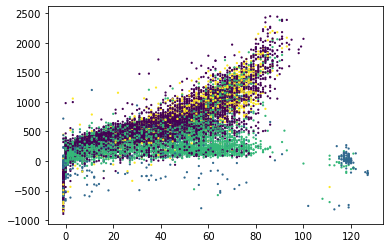

In [151]:
plt.scatter(df.PV90[::1000], df.TCG50[::1000], alpha=1, s=5, edgecolor='None', c=df.Wetland[::1000])

In [202]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=2)

In [231]:
pca.fit(np.nan_to_num(clf_features[::100]))

PCA(n_components=2)

In [232]:
pca_f = pca.transform(np.nan_to_num(clf_features[::10]))

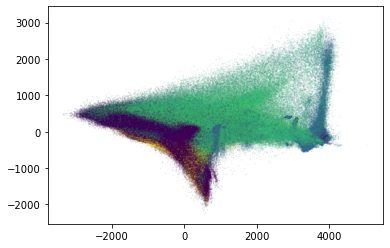

In [233]:
plt.scatter(pca_f[:, 0], pca_f[:, 1], c=df.Wetland[::10], s=2, alpha=0.1, edgecolor='None')

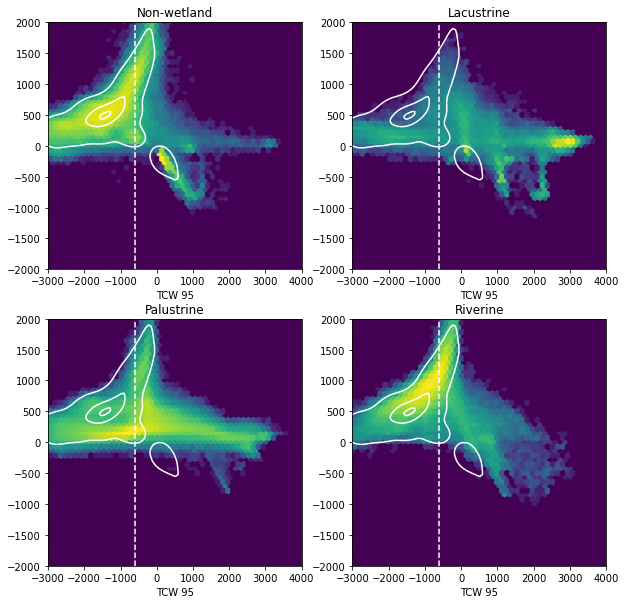

In [277]:
plt.figure(figsize=(10, 10))
mask = (df.Wetland == 0)[::10]
import scipy.ndimage
xvals = df.TCW95[::10]
yvals = df.TCG50[::10]
hist, xedg, yedg = np.histogram2d(xvals[mask], yvals[mask], bins=100)
hist = scipy.ndimage.gaussian_filter(hist, 2)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    mask = (df.Wetland == i)[::10]
    plt.hexbin(xvals[mask], yvals[mask], gridsize=50, bins='log', extent=(-3000, 4000, -2000, 2000))
    plt.contour(xedg[:-1], yedg[:-1], hist.T, np.percentile(hist, [90, 99, 99.9]), colors='white')
    plt.title((['Non-wetland'] + wetland_classes)[i])
    plt.ylim(-2000, 2000)
    plt.xlim(-3000, 4000)
    plt.xlabel('TCW 95')
    plt.axvline(-600, c='white', linestyle='--')

In [257]:
pca.components_.round(2)

array([[ 0.99, -0.05,  0.  , -0.  ,  0.  , -0.  ,  0.11,  0.01,  0.05,
         0.  ],
       [-0.1 , -0.72, -0.03, -0.03,  0.  , -0.  ,  0.65,  0.04, -0.22,
        -0.  ]])

Let's look at balanced accuracy/precision/recall as a function of Koppen zone vs MrVBF.

In [338]:
def mask_accuracy(assess_mask):
    agree_grid = np.zeros((16, 10))  # Koppen x MrVBF
    n_grid = np.zeros((16, 10))  # This one stores the number of entries, rather than the statistic, for later mean calculation.
    for koppen_idx in tqdm(range(16)):
        for vbf_idx in range(10):
            mask = (df.MrVBF == vbf_idx) & (df.Koppen == koppen_idx)
            df_ = df[mask]
            matches = assess_mask[mask] & (df_.Wetland > 0)
            agree_grid[koppen_idx, vbf_idx] += matches.sum()
            n_grid[koppen_idx, vbf_idx] += matches.size
    return agree_grid, n_grid, agree_grid / n_grid

In [339]:
gab_accuracy = mask_accuracy(gabrielle_mask)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [340]:
tcw_accuracy = mask_accuracy(df.TCW95 > -600)

/g/data/v10/public/modules/dea-env/20200612/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
predictions_all_2 = clf2.predict(np.nan_to_num(clf_features.reshape((-1, clf_features.shape[-1])))).reshape(clf_features.shape[:-1])

In [ ]:
clf2_accuracy = mask_accuracy(predictions_all_2)

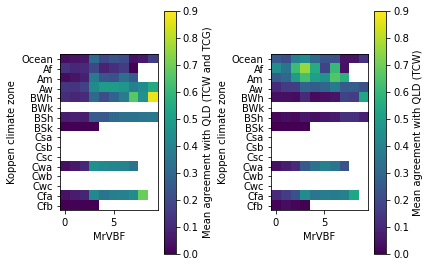

In [348]:
plt.subplot(1, 2, 1)
plt.imshow(gab_accuracy[-1], vmin=0, vmax=0.9)
plt.xlabel('MrVBF')
plt.ylabel('Koppen climate zone')
plt.yticks(range(16), koppen_titles)
cb = plt.colorbar()
cb.set_label('Mean agreement with QLD (TCW and TCG)')
plt.subplot(1, 2, 2)
plt.imshow(tcw_accuracy[-1], vmin=0, vmax=0.9)
plt.xlabel('MrVBF')
plt.ylabel('Koppen climate zone')
plt.yticks(range(16), koppen_titles)
cb = plt.colorbar()
cb.set_label('Mean agreement with QLD (TCW)')
plt.tight_layout()